# Week 8 Supervised Learning

## Practicum 8-1

PR8-1: Regressiemodellen in Machine Learning. Great Outdoors wil graag weten hoeveel zij gaat verkopen op basis van een set onafhankelijke variabelen. Daarom wil zij een model trainen op basis van reeds bekende data, zodat deze volgend jaar in gebruik kan worden genomen. Je doet dus het volgende met de reeds bekende data:

* Bedenk met welke onafhankelijke variabelen, die ook uit meerdere databasetabellen kunnen komen, dit naar verwachting het beste voorspeld kan worden en zet deze samen met de afhankelijke variabele in één DataFrame.
* Pas waar nodig Dummy Encoding toe.
* Snijd dit DataFrame horizontaal en verticaal op de juiste manier.
* Train het regressiemodel.
* Evalueer de performance van je getrainde regressiemodel.

### Tables 1/2

Hieronder zie je de tabellen die we gaan gebruiken voor deze practicumopdracht van 8-1.

In [1]:
# age_group
# sales_demographic
# sales_territory

# order_details
# order_header
# order_method

# product
# product_line
# product_type

# sales_branch
# SALES_TARGETData

### Imports

Hier staan alle imports die gebruikt zullen worden voor de practicumopdrachten 8-1 en 8-2.

In [2]:
import sqlite3 as sql
import warnings as warn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from typing import Any
warn.filterwarnings("ignore")

### SQLite connections and CSV-files

Hier maken we de connectie naar de SQLite Databases en roepen we de CSV bestanden aan.

In [3]:
conn1 = sql.connect("Great_Outdoors_Data_SQLite/go_crm.sqlite")
conn2 = sql.connect("Great_Outdoors_Data_SQLite/go_sales.sqlite")
conn3 = sql.connect("Great_Outdoors_Data_SQLite/go_staff.sqlite")

go_sales_inventory_levelsdata = pd.read_csv("Great_Outdoors_Data_SQLite/GO_SALES_INVENTORY_LEVELSData.csv")
go_sales_product_forecastdata = pd.read_csv("Great_Outdoors_Data_SQLite/GO_SALES_PRODUCT_FORECASTData.csv")

### Check all tables

Hieronder wordt gecheckt welke tabellen er nou in Python zitten.

In [4]:
print(globals().keys())

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__vsc_ipynb_file__', '_i', '_ii', '_iii', '_i1', '_i2', 'sql', 'warn', 'pd', 'plt', 'np', 'train_test_split', 'LinearRegression', 'mean_squared_error', 'mean_absolute_error', 'Any', '_i3', 'conn1', 'conn2', 'conn3', 'go_sales_inventory_levelsdata', 'go_sales_product_forecastdata', '_i4'])


### Check all tables of the SQLite databases.

Hier checken we alle DataFrames van de tabellen voor een snel overzicht.

In [5]:
# Iterate over all tables from the conns.
for i, conn in enumerate([conn1, conn2, conn3]):
    tables: list[Any] = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

    for table in tables:
        globals()[table[0] + str(i)] = pd.read_sql_query(f"SELECT * FROM {table[0]}", conn)
        print(globals()[table[0] + str(i)])

  AGE_GROUP_CODE UPPER_AGE LOWER_AGE TRIAL219
0              1        20         0        T
1              2        30        21        T
2              3        40        31        T
3              4        50        41        T
4              5        60        51        T
5              6        70        61        T
   COUNTRY_CODE      COUNTRY_EN FLAG_IMAGE SALES_TERRITORY_CODE TRIAL219
0             1          France        F01                    6        T
1            10          Sweden        F10                    5        T
2            11           Japan        F11                    4        T
3            12          Taiwan        F12                    4        T
4            13           Korea        F13                    4        T
5            14           China        F14                    4        T
6            16       Australia        F15                    4        T
7            17         Belgium        F16                    6        T
8            18      

      ORDER_DETAIL_CODE ORDER_NUMBER PRODUCT_NUMBER  QUANTITY UNIT_COST  \
0                100000         8462             96        16      16.1   
1                100001         9111             96        20      16.1   
2                100002         8451             96        24      16.1   
3                100003         8453             96        18      16.1   
4                100004         8439             96        20      16.1   
...                 ...          ...            ...       ...       ...   
43058             99995         8459             95       146      2.76   
43059             99996         8457             95       172      2.76   
43060             99997         9267             95       192      2.76   
43061             99998         8441             95       192      2.76   
43062             99999         8440             96        22      16.1   

      UNIT_PRICE UNIT_SALE_PRICE TRIAL879  
0          22.54           22.54        T  
1          

### For quick testing the necassery tables

We kunnen snel de inhoud zien van de tabellen.

In [6]:
test = pd.read_sql_query(f"SELECT * FROM SALES_TARGETData", conn2)
test

# TRIAL column not taken into account
# age_group => 3 columns
# sales_demographic => 4 columns
# sales_territory => 2 columns
# 9 columns

# order_details => 7 columns
# order_header => 8 columns
# order_method => 2 columns
# 17 columns

# product => 9 columns
# product_line => 2 columns
# product_type => 3 columns
# 14 columns

# sales_branch => 7 columns
# SALES_TARGETData => 8 columns
# 15 columns
# 55 columns in total - 10 columns = 45 columns

,Id,SALES_STAFF_CODE,SALES_YEAR,SALES_PERIOD,RETAILER_NAME,PRODUCT_NUMBER,SALES_TARGET,RETAILER_CODE,TRIAL888
0,1,6,2021,5,Altitudes extrêmes,53,489,33,T
1,2,6,2021,5,Altitudes extrêmes,55,666,33,T
2,3,6,2021,5,Altitudes extrêmes,56,682,33,T
3,4,6,2021,5,Camping Sauvage,76,3193,35,T
4,5,6,2021,5,Camping Sauvage,85,7236,35,T
...,...,...,...,...,...,...,...,...,...
39525,39526,83,2020,8,Golf Shop Jiro,107,4683,129,T
39526,39527,83,2021,3,Japan Sports Youhinten,33,497,130,T
39527,39528,83,2021,3,Kitanaka Tozanyouhinten,43,1564,133,T
39528,39529,83,2021,3,Kitanaka Tozanyouhinten,60,600,133,T


### Tables 2/2

Tabellen die we gaan gebruiken voor het trainen en testen van de data voor opdracht 8-1.

In [7]:
# Remove tables that we not gonna use.
go_tables: list[str] = ["age_group0", "sales_demographic0", "sales_territory0", "order_details1", "order_header1", 
    "order_method1", "product1", "product_line1", "product_type1", "sales_branch1", "SALES_TARGETData1"
]

### Merge the tables

Hier voegen we de tabellen samen, zodat we betere voorspellingen kunnen maken.

In [8]:
def go_merge(go_table: Any):
    df_merge: list[Any] = [globals()[table] for table in go_table]
    merged_df = pd.concat(df_merge, ignore_index=True)

    return merged_df

### Drop unnecassary columns 1/2

Hier verwijderen we de nutteloze TRIAL kolommen.

In [9]:
trial = go_merge(go_tables)
df = trial[trial.columns.drop(list(trial.filter(regex="TRIAL")))]

### Show all the columns

We tonen alle kolommen en filteren de lege waardes eruit bij de volgende stap.

In [10]:
#Here we display all the columns
pd.set_option("display.max_columns", None)
df

,AGE_GROUP_CODE,UPPER_AGE,LOWER_AGE,DEMOGRAPHIC_CODE,RETAILER_CODEMR,SALES_PERCENT,SALES_TERRITORY_CODE,TERRITORY_NAME_EN,ORDER_DETAIL_CODE,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETAILER_NAME,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_DATE,ORDER_METHOD_CODE,ORDER_METHOD_EN,INTRODUCTION_DATE,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,PRODUCT_IMAGE,LANGUAGE,PRODUCT_NAME,DESCRIPTION,PRODUCT_LINE_CODE,PRODUCT_LINE_EN,PRODUCT_TYPE_EN,ADDRESS1,ADDRESS2,CITY,REGION,POSTAL_ZONE,COUNTRY_CODE,Id,SALES_YEAR,SALES_PERIOD,SALES_TARGET,RETAILER_CODE
0,1,20,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,30,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,40,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,50,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,60,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107,NaN,NaN,NaN,NaN,Golf Shop Jiro,NaN,NaN,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39526.0,2020,8,4683,129
90620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,NaN,NaN,NaN,NaN,Japan Sports Youhinten,NaN,NaN,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39527.0,2021,3,497,130
90621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43,NaN,NaN,NaN,NaN,Kitanaka Tozanyouhinten,NaN,NaN,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39528.0,2021,3,1564,133
90622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60,NaN,NaN,NaN,NaN,Kitanaka Tozanyouhinten,NaN,NaN,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39529.0,2021,3,600,133


### Delete unnecassary columns 2/2

Hier verwijderen we kolommen die geen waarde hebben op het regressiemodel.

In [11]:
df = df.drop(columns=[
    "RETAILER_NAME", "ADDRESS1", "ADDRESS2", "CITY", "REGION", "POSTAL_ZONE", "PRODUCT_IMAGE", "PRODUCT_NAME", "DESCRIPTION",
    "TERRITORY_NAME_EN", "ORDER_METHOD_EN", "LANGUAGE", "PRODUCT_LINE_EN", "PRODUCT_TYPE_EN"
])
df = df.fillna(0)
df

,AGE_GROUP_CODE,UPPER_AGE,LOWER_AGE,DEMOGRAPHIC_CODE,RETAILER_CODEMR,SALES_PERCENT,SALES_TERRITORY_CODE,ORDER_DETAIL_CODE,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_DATE,ORDER_METHOD_CODE,INTRODUCTION_DATE,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,PRODUCT_LINE_CODE,COUNTRY_CODE,Id,SALES_YEAR,SALES_PERIOD,SALES_TARGET,RETAILER_CODE
0,1,20,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0
1,2,30,21,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0
2,3,40,31,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0
3,4,50,41,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0
4,5,60,51,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90619,0,0,0,0,0,0,0,0,0,107,0.0,0,0,0,0,0,83,0,0,0,0,0,0,0,0,0,39526.0,2020,8,4683,129
90620,0,0,0,0,0,0,0,0,0,33,0.0,0,0,0,0,0,83,0,0,0,0,0,0,0,0,0,39527.0,2021,3,497,130
90621,0,0,0,0,0,0,0,0,0,43,0.0,0,0,0,0,0,83,0,0,0,0,0,0,0,0,0,39528.0,2021,3,1564,133
90622,0,0,0,0,0,0,0,0,0,60,0.0,0,0,0,0,0,83,0,0,0,0,0,0,0,0,0,39529.0,2021,3,600,133


### Convert the columns to numeric types

Alle kolommen worden naar numerieke waardes omgezet, zodat ze bruikbaar zijn voor de regressiemodellen.

In [12]:
# Convert all remaining columns to numeric types
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors="coerce")

### Horizontal and vertical cut

We snijden horizontaal en verticaal, zodat we het model kunnen trainen en testen. Ook vullen we defaults in voor X.

In [13]:
X = df.drop(columns=["SALES_PERCENT"])
y = df["SALES_PERCENT"]
X = X.fillna(0)
X

,AGE_GROUP_CODE,UPPER_AGE,LOWER_AGE,DEMOGRAPHIC_CODE,RETAILER_CODEMR,SALES_TERRITORY_CODE,ORDER_DETAIL_CODE,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_DATE,ORDER_METHOD_CODE,INTRODUCTION_DATE,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,PRODUCT_LINE_CODE,COUNTRY_CODE,Id,SALES_YEAR,SALES_PERIOD,SALES_TARGET,RETAILER_CODE
0,1,20,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0,0.0,0,0,0,0
1,2,30,21,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0,0.0,0,0,0,0
2,3,40,31,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0,0.0,0,0,0,0
3,4,50,41,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0,0.0,0,0,0,0
4,5,60,51,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90619,0,0,0,0,0,0,0,0,107,0.0,0.0,0.0,0.0,0,0,83,0,0.0,0,0.0,0,0.0,0.0,0,0,39526.0,2020,8,4683,129
90620,0,0,0,0,0,0,0,0,33,0.0,0.0,0.0,0.0,0,0,83,0,0.0,0,0.0,0,0.0,0.0,0,0,39527.0,2021,3,497,130
90621,0,0,0,0,0,0,0,0,43,0.0,0.0,0.0,0.0,0,0,83,0,0.0,0,0.0,0,0.0,0.0,0,0,39528.0,2021,3,1564,133
90622,0,0,0,0,0,0,0,0,60,0.0,0.0,0.0,0.0,0,0,83,0,0.0,0,0.0,0,0.0,0.0,0,0,39529.0,2021,3,600,133


### Train and test data

Hier kunnen we eindelijk de data trainen en testen die we nodig hebben.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model: LinearRegression = LinearRegression()
model.fit(X_train, y_train)
model

LinearRegression()

### Predict the model

We kunnen het model met de test data van de onafhankelijke waarde voorspellen.

In [15]:
y_pred = model.predict(X_test)
y_pred

array([ 0.94418723, -0.12738267,  0.85285252, ...,  1.15602694,
        0.76804381,  0.23274776])

### Get a new predicted column

We maken een nieuwe kolom aan met een nieuwe naam die we met het oude kolom kunnen vergelijken.

In [16]:
df_pred = pd.DataFrame(y_pred)
df_pred = df_pred.rename(columns={0: "PREDICTED_SALES_PERCENT"})
df_pred

,PREDICTED_SALES_PERCENT
0,0.944187
1,-0.127383
2,0.852853
3,0.154182
4,0.535235
...,...
13589,0.064345
13590,1.058851
13591,1.156027
13592,0.768044


### Concat old column with new column

We vergelijken beide kolommen door ze samen te voegen.

In [17]:
y_test_merge = pd.concat([y_test.reset_index()["SALES_PERCENT"], df_pred], axis=1)
y_test_merge.loc[y_test_merge["PREDICTED_SALES_PERCENT"].notna(), :]

,SALES_PERCENT,PREDICTED_SALES_PERCENT
0,0,0.944187
1,0,-0.127383
2,0,0.852853
3,0,0.154182
4,0,0.535235
...,...,...
13589,0,0.064345
13590,0,1.058851
13591,0,1.156027
13592,0,0.768044


### Show the predictions for the columns

Met Matplotlib kunnen we wederom weer in een grafiek de tabellen met elkaar vergelijken en voorspellen.

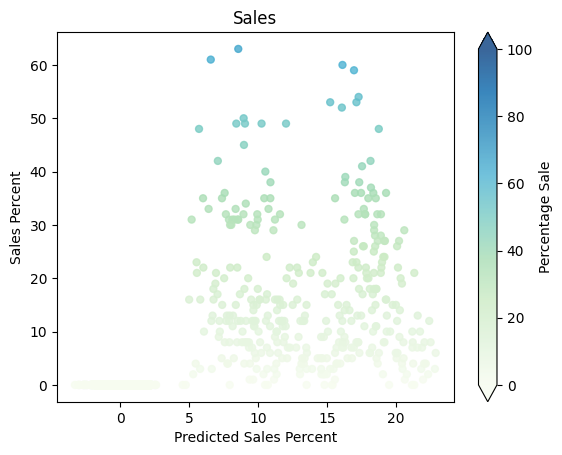

In [18]:
colors = np.interp(y_test_merge["SALES_PERCENT"], (y_test_merge["SALES_PERCENT"].min(), y_test_merge["SALES_PERCENT"].max()), (0, 66))

plt.xlabel("Predicted Sales Percent")
plt.ylabel("Sales Percent")
plt.title("Sales")
plt.scatter(x=y_test_merge["PREDICTED_SALES_PERCENT"], y=y_test_merge["SALES_PERCENT"], s=25, c=colors, cmap="GnBu", alpha=0.8)
plt.colorbar(orientation="vertical", label="Percentage Sale", extend="both")
plt.clim(0, 100)
plt.show()

### Measure mean errors for squared and absolute

We berekenen voor beide squared en absolute de error, zodat we kunnen zien hoe goed het model werkt.

In [19]:
mean_squared_error(y_test_merge["SALES_PERCENT"], y_test_merge["PREDICTED_SALES_PERCENT"])

5.674171857133748

In [20]:
mean_absolute_error(y_test_merge["SALES_PERCENT"], y_test_merge["PREDICTED_SALES_PERCENT"])

0.6049420499003197